In [ ]:
pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 19.5 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score, classification_report, f1_score
from sklearn.ensemble import IsolationForest
import optuna
from imblearn.over_sampling import SMOTE
import xgboost as xgb
from xgboost import XGBClassifier
from google.colab import files

In [ ]:
column_names = [
    'unit_number', 'time_in_cycles', 'op_setting_1', 'op_setting_2', 'op_setting_3',
    'sensor_1', 'sensor_2', 'sensor_3', 'sensor_4', 'sensor_5',
    'sensor_6', 'sensor_7', 'sensor_8', 'sensor_9', 'sensor_10',
    'sensor_11', 'sensor_12', 'sensor_13', 'sensor_14', 'sensor_15',
    'sensor_16', 'sensor_17', 'sensor_18', 'sensor_19', 'sensor_20', 'sensor_21'
]

telemetry = pd.read_csv("/content/test_FD004.txt", delim_whitespace=True, header=None, names=column_names)

<ipython-input-3-965b8f53a013>:9: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  telemetry = pd.read_csv("/content/test_FD004.txt", delim_whitespace=True, header=None, names=column_names)


In [ ]:
print(telemetry)
telemetry_test_processed = telemetry

       unit_number  time_in_cycles  op_setting_1  op_setting_2  op_setting_3  \
0                1               1       20.0072        0.7000         100.0   
1                1               2       24.9984        0.6200          60.0   
2                1               3       42.0000        0.8420         100.0   
3                1               4       42.0035        0.8402         100.0   
4                1               5       35.0079        0.8400         100.0   
...            ...             ...           ...           ...           ...   
41209          248             277       41.9991        0.8401         100.0   
41210          248             278       20.0026        0.7005         100.0   
41211          248             279       34.9988        0.8413         100.0   
41212          248             280       20.0027        0.7000         100.0   
41213          248             281       35.0075        0.8402         100.0   

       sensor_1  sensor_2  sensor_3  se

In [ ]:
feature_all_cols = [col for col in telemetry.columns if 'sensor_' in col or 'op_setting_' in col]

In [ ]:
WINDOW_SIZE = 10
LAG_VALUES = [1, 2, 3]

# Load data
column_names = [
    'unit_number', 'time_in_cycles', 'op_setting_1', 'op_setting_2', 'op_setting_3',
    'sensor_1', 'sensor_2', 'sensor_3', 'sensor_4', 'sensor_5',
    'sensor_6', 'sensor_7', 'sensor_8', 'sensor_9', 'sensor_10',
    'sensor_11', 'sensor_12', 'sensor_13', 'sensor_14', 'sensor_15',
    'sensor_16', 'sensor_17', 'sensor_18', 'sensor_19', 'sensor_20', 'sensor_21'
]
df = pd.read_csv("/content/test_FD004.txt", delim_whitespace=True, header=None, names=column_names)

# Select features (can be all sensors or a subset)
feature_cols = [col for col in df.columns if 'sensor_' in col]

# List to collect new feature DataFrames
features_to_concat = []

# Rolling mean and std
for col in feature_cols:
    roll_mean = df.groupby('unit_number')[col].transform(lambda x: x.rolling(WINDOW_SIZE, min_periods=1).mean())
    roll_std = df.groupby('unit_number')[col].transform(lambda x: x.rolling(WINDOW_SIZE, min_periods=1).std())
    diff = df.groupby('unit_number')[col].diff()

    features_to_concat.extend([
        roll_mean.rename(f'{col}_roll_mean_w{WINDOW_SIZE}'),
        roll_std.rename(f'{col}_roll_std_w{WINDOW_SIZE}'),
        diff.rename(f'{col}_diff')
    ])

# Lag features
for lag in LAG_VALUES:
    for col in feature_cols:
        lagged = df.groupby('unit_number')[col].shift(lag)
        features_to_concat.append(lagged.rename(f'{col}_lag_{lag}'))

# Z-score features
for col in feature_cols:
    zscore = (df[col] - df[col].mean()) / (df[col].std() + 1e-6)
    features_to_concat.append(zscore.rename(f'{col}_zscore'))

# Combine all features efficiently
new_features_df = pd.concat(features_to_concat, axis=1)

# Combine with original DataFrame if needed
df_final = pd.concat([df.reset_index(drop=True), new_features_df.reset_index(drop=True)], axis=1)
telemetry = df_final.copy()#Copy of the dataset after Feature Engineering

<ipython-input-6-f408750bc839>:12: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv("/content/test_FD004.txt", delim_whitespace=True, header=None, names=column_names)


In [ ]:
feature_cols_updated = ['op_setting_1', 'op_setting_2', 'op_setting_3', 'sensor_1', 'sensor_2', 'sensor_3', 'sensor_4', 'sensor_6', 'sensor_7', 'sensor_8', 'sensor_9', 'sensor_10', 'sensor_11', 'sensor_12', 'sensor_13', 'sensor_14', 'sensor_15', 'sensor_16', 'sensor_17', 'sensor_20', 'sensor_21', 'sensor_1_roll_mean_w10', 'sensor_1_roll_std_w10', 'sensor_1_diff', 'sensor_2_roll_mean_w10', 'sensor_2_roll_std_w10', 'sensor_2_diff', 'sensor_3_roll_mean_w10', 'sensor_3_roll_std_w10', 'sensor_3_diff', 'sensor_4_roll_mean_w10', 'sensor_4_roll_std_w10', 'sensor_4_diff', 'sensor_5_roll_mean_w10', 'sensor_5_roll_std_w10', 'sensor_5_diff', 'sensor_6_roll_mean_w10', 'sensor_6_roll_std_w10', 'sensor_6_diff', 'sensor_7_roll_mean_w10', 'sensor_7_roll_std_w10', 'sensor_7_diff', 'sensor_8_roll_mean_w10', 'sensor_8_roll_std_w10', 'sensor_8_diff', 'sensor_9_roll_mean_w10', 'sensor_9_roll_std_w10', 'sensor_9_diff', 'sensor_10_roll_mean_w10', 'sensor_10_roll_std_w10', 'sensor_10_diff', 'sensor_11_roll_mean_w10', 'sensor_11_roll_std_w10', 'sensor_11_diff', 'sensor_12_roll_mean_w10', 'sensor_12_roll_std_w10', 'sensor_12_diff', 'sensor_13_roll_mean_w10', 'sensor_13_roll_std_w10', 'sensor_13_diff', 'sensor_14_roll_mean_w10', 'sensor_14_roll_std_w10', 'sensor_14_diff', 'sensor_15_roll_mean_w10', 'sensor_15_roll_std_w10', 'sensor_15_diff', 'sensor_16_roll_mean_w10', 'sensor_16_roll_std_w10', 'sensor_17_roll_mean_w10', 'sensor_17_roll_std_w10', 'sensor_17_diff', 'sensor_18_roll_mean_w10', 'sensor_18_roll_std_w10', 'sensor_18_diff', 'sensor_20_roll_mean_w10', 'sensor_20_roll_std_w10', 'sensor_20_diff', 'sensor_21_roll_mean_w10', 'sensor_21_roll_std_w10', 'sensor_21_diff', 'sensor_1_lag_1', 'sensor_2_lag_1', 'sensor_3_lag_1', 'sensor_4_lag_1', 'sensor_6_lag_1', 'sensor_7_lag_1', 'sensor_8_lag_1', 'sensor_9_lag_1', 'sensor_10_lag_1', 'sensor_11_lag_1', 'sensor_12_lag_1', 'sensor_13_lag_1', 'sensor_14_lag_1', 'sensor_15_lag_1', 'sensor_16_lag_1', 'sensor_17_lag_1', 'sensor_20_lag_1', 'sensor_21_lag_1', 'sensor_1_lag_2', 'sensor_2_lag_2', 'sensor_3_lag_2', 'sensor_4_lag_2', 'sensor_6_lag_2', 'sensor_7_lag_2', 'sensor_8_lag_2', 'sensor_9_lag_2', 'sensor_10_lag_2', 'sensor_11_lag_2', 'sensor_12_lag_2', 'sensor_13_lag_2', 'sensor_14_lag_2', 'sensor_15_lag_2', 'sensor_17_lag_2', 'sensor_20_lag_2', 'sensor_21_lag_2', 'sensor_1_lag_3', 'sensor_2_lag_3', 'sensor_3_lag_3', 'sensor_4_lag_3', 'sensor_6_lag_3', 'sensor_7_lag_3', 'sensor_8_lag_3', 'sensor_9_lag_3', 'sensor_10_lag_3', 'sensor_11_lag_3', 'sensor_12_lag_3', 'sensor_13_lag_3', 'sensor_14_lag_3', 'sensor_15_lag_3', 'sensor_16_lag_3', 'sensor_17_lag_3', 'sensor_20_lag_3', 'sensor_21_lag_3', 'sensor_6_zscore', 'sensor_7_zscore', 'sensor_13_zscore', 'sensor_14_zscore', 'sensor_21_zscore']

In [ ]:
feature_cols = [x for x in feature_all_cols and feature_cols_updated]

**The feature in "feature_cols" are gonna be used for our analysis**

In [ ]:
print(feature_cols)

['op_setting_1', 'op_setting_2', 'op_setting_3', 'sensor_1', 'sensor_2', 'sensor_3', 'sensor_4', 'sensor_6', 'sensor_7', 'sensor_8', 'sensor_9', 'sensor_10', 'sensor_11', 'sensor_12', 'sensor_13', 'sensor_14', 'sensor_15', 'sensor_16', 'sensor_17', 'sensor_20', 'sensor_21', 'sensor_1_roll_mean_w10', 'sensor_1_roll_std_w10', 'sensor_1_diff', 'sensor_2_roll_mean_w10', 'sensor_2_roll_std_w10', 'sensor_2_diff', 'sensor_3_roll_mean_w10', 'sensor_3_roll_std_w10', 'sensor_3_diff', 'sensor_4_roll_mean_w10', 'sensor_4_roll_std_w10', 'sensor_4_diff', 'sensor_5_roll_mean_w10', 'sensor_5_roll_std_w10', 'sensor_5_diff', 'sensor_6_roll_mean_w10', 'sensor_6_roll_std_w10', 'sensor_6_diff', 'sensor_7_roll_mean_w10', 'sensor_7_roll_std_w10', 'sensor_7_diff', 'sensor_8_roll_mean_w10', 'sensor_8_roll_std_w10', 'sensor_8_diff', 'sensor_9_roll_mean_w10', 'sensor_9_roll_std_w10', 'sensor_9_diff', 'sensor_10_roll_mean_w10', 'sensor_10_roll_std_w10', 'sensor_10_diff', 'sensor_11_roll_mean_w10', 'sensor_11_roll

In [ ]:

cols_with_potential_nans = [f'{col}_diff' for col in feature_all_cols] + [f'{col}_roll_std_w{WINDOW_SIZE}' for col in feature_all_cols]

for col_name in cols_with_potential_nans:
    if col_name in telemetry.columns:
        telemetry[col_name] = telemetry.groupby('unit_number')[col_name].transform(
            lambda x: x.bfill().ffill()
        )
nan_check = telemetry.isnull().sum()
telemetry.fillna(0, inplace=True)
if nan_check.sum() == 0:
    print("No NaN values remaining.")
else:
    print(nan_check[nan_check > 0])


sensor_1_lag_1     248
sensor_2_lag_1     248
sensor_3_lag_1     248
sensor_4_lag_1     248
sensor_5_lag_1     248
                  ... 
sensor_17_lag_3    744
sensor_18_lag_3    744
sensor_19_lag_3    744
sensor_20_lag_3    744
sensor_21_lag_3    744
Length: 63, dtype: int64


In [ ]:
df = telemetry.copy()

rul_df = df.groupby('unit_number')['time_in_cycles'].max().reset_index()
rul_df.columns = ['unit_number', 'max_cycle']


df = df.merge(rul_df, on='unit_number', how='left')

# Step 3: Calculate RUL
df['RUL'] = df['max_cycle'] - df['time_in_cycles']

# Step 4: Create binary failure label (1 if within threshold cycles of failure)
THRESHOLD = 20
df['label'] = df['RUL'].apply(lambda x: 1 if x <= THRESHOLD else 0)
telemetry = df
print("\n The Data is ready")


 The Data is ready


In [ ]:
telemetry.to_csv('telemetry_dataset.csv', index=False)
files.download('telemetry_dataset.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#Auto tune the threshold here

In [ ]:
df_model = telemetry.copy()

X = df_model.drop(columns=['unit_number', 'time_in_cycles', 'RUL', 'label'])
y_reg = df_model['RUL']
y_clf = df_model['label']

# Common train/test split
X_train, X_test, y_train_reg, y_test_reg = train_test_split(X, y_reg, test_size=0.2, random_state=42)
_, _, y_train_clf, y_test_clf = train_test_split(X, y_clf, test_size=0.2, random_state=42)

# =============================
# 2. Regressor Optuna Tuning
# =============================

def objective_reg(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_float('subsample', 0.7, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.7, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 0.5),
        'random_state': 42,
        'objective': 'reg:squarederror'
    }

    model = xgb.XGBRegressor(**params)
    model.fit(X_train, y_train_reg, eval_set=[(X_test, y_test_reg)])
    preds = model.predict(X_test)
    rmse = mean_squared_error(y_test_reg, preds)
    return rmse

study_reg = optuna.create_study(direction='minimize')
study_reg.optimize(objective_reg, n_trials=10)

print("\n Best Regressor Params:", study_reg.best_params)

# Train final regressor
best_regressor = xgb.XGBRegressor(**study_reg.best_params)
best_regressor.fit(X_train, y_train_reg)
y_pred_rul = best_regressor.predict(X_test)



[I 2025-05-31 09:30:08,796] A new study created in memory with name: no-name-0e3665b2-41dd-4900-aa87-d9423b0d1fb4


[0]	validation_0-rmse:75.10377
[1]	validation_0-rmse:68.72033
[2]	validation_0-rmse:63.44343
[3]	validation_0-rmse:59.35887
[4]	validation_0-rmse:56.17613
[5]	validation_0-rmse:55.14290
[6]	validation_0-rmse:52.86869
[7]	validation_0-rmse:50.97865
[8]	validation_0-rmse:49.47227
[9]	validation_0-rmse:48.32563
[10]	validation_0-rmse:47.30950
[11]	validation_0-rmse:46.46970
[12]	validation_0-rmse:45.70769
[13]	validation_0-rmse:44.95809
[14]	validation_0-rmse:44.58013
[15]	validation_0-rmse:44.15835
[16]	validation_0-rmse:43.66533
[17]	validation_0-rmse:43.30934
[18]	validation_0-rmse:42.91553
[19]	validation_0-rmse:42.44598
[20]	validation_0-rmse:42.08848
[21]	validation_0-rmse:41.67600
[22]	validation_0-rmse:41.37234
[23]	validation_0-rmse:41.20109
[24]	validation_0-rmse:40.87853
[25]	validation_0-rmse:40.54137
[26]	validation_0-rmse:40.32748
[27]	validation_0-rmse:40.04381
[28]	validation_0-rmse:39.84841
[29]	validation_0-rmse:39.52014
[30]	validation_0-rmse:39.26511
[31]	validation_0-

[I 2025-05-31 09:31:22,085] Trial 0 finished with value: 1251.457275390625 and parameters: {'n_estimators': 159, 'max_depth': 10, 'learning_rate': 0.16505626521612635, 'subsample': 0.8003349878258825, 'colsample_bytree': 0.9509240937259091, 'gamma': 0.01634246887449531}. Best is trial 0 with value: 1251.457275390625.


[0]	validation_0-rmse:78.77277
[1]	validation_0-rmse:77.49678
[2]	validation_0-rmse:73.55761
[3]	validation_0-rmse:70.16830
[4]	validation_0-rmse:69.21397
[5]	validation_0-rmse:68.44960
[6]	validation_0-rmse:65.89294
[7]	validation_0-rmse:65.30653
[8]	validation_0-rmse:63.02992
[9]	validation_0-rmse:61.05910
[10]	validation_0-rmse:59.45228
[11]	validation_0-rmse:58.12340
[12]	validation_0-rmse:56.98008
[13]	validation_0-rmse:55.93466
[14]	validation_0-rmse:55.07505
[15]	validation_0-rmse:54.29995
[16]	validation_0-rmse:53.62269
[17]	validation_0-rmse:53.09742
[18]	validation_0-rmse:52.61477
[19]	validation_0-rmse:52.17385
[20]	validation_0-rmse:51.70180
[21]	validation_0-rmse:51.28873
[22]	validation_0-rmse:50.97015
[23]	validation_0-rmse:50.73290
[24]	validation_0-rmse:50.62733
[25]	validation_0-rmse:50.28216
[26]	validation_0-rmse:49.98114
[27]	validation_0-rmse:49.81149
[28]	validation_0-rmse:49.56575
[29]	validation_0-rmse:49.31840
[30]	validation_0-rmse:49.10753
[31]	validation_0-

[I 2025-05-31 09:31:57,825] Trial 1 finished with value: 1344.6898193359375 and parameters: {'n_estimators': 184, 'max_depth': 6, 'learning_rate': 0.10531337551905634, 'subsample': 0.8363159823383286, 'colsample_bytree': 0.7006888527756748, 'gamma': 0.18216139526552727}. Best is trial 0 with value: 1251.457275390625.


[0]	validation_0-rmse:74.95489
[1]	validation_0-rmse:68.77712
[2]	validation_0-rmse:64.14456
[3]	validation_0-rmse:60.78928
[4]	validation_0-rmse:58.36612
[5]	validation_0-rmse:57.45483
[6]	validation_0-rmse:55.81116
[7]	validation_0-rmse:55.25288
[8]	validation_0-rmse:54.16523
[9]	validation_0-rmse:53.30024
[10]	validation_0-rmse:52.64528
[11]	validation_0-rmse:52.04107
[12]	validation_0-rmse:51.53751
[13]	validation_0-rmse:51.17708
[14]	validation_0-rmse:50.94947
[15]	validation_0-rmse:50.51556
[16]	validation_0-rmse:50.02047
[17]	validation_0-rmse:49.81632
[18]	validation_0-rmse:49.43691
[19]	validation_0-rmse:49.22114
[20]	validation_0-rmse:48.89188
[21]	validation_0-rmse:48.54953
[22]	validation_0-rmse:48.15244
[23]	validation_0-rmse:47.88106
[24]	validation_0-rmse:47.46790
[25]	validation_0-rmse:47.26258
[26]	validation_0-rmse:46.95856
[27]	validation_0-rmse:46.63279
[28]	validation_0-rmse:46.45619
[29]	validation_0-rmse:46.27489
[30]	validation_0-rmse:46.02125
[31]	validation_0-

[I 2025-05-31 09:32:15,031] Trial 2 finished with value: 1375.2540283203125 and parameters: {'n_estimators': 154, 'max_depth': 5, 'learning_rate': 0.2059404138482422, 'subsample': 0.7769891345699553, 'colsample_bytree': 0.9165339623381525, 'gamma': 0.2683537069292793}. Best is trial 0 with value: 1251.457275390625.


[0]	validation_0-rmse:76.76534
[1]	validation_0-rmse:71.44128
[2]	validation_0-rmse:67.08631
[3]	validation_0-rmse:63.54625
[4]	validation_0-rmse:60.63009
[5]	validation_0-rmse:59.67588
[6]	validation_0-rmse:57.49259
[7]	validation_0-rmse:56.86685
[8]	validation_0-rmse:55.25166
[9]	validation_0-rmse:53.86270
[10]	validation_0-rmse:52.66621
[11]	validation_0-rmse:51.78443
[12]	validation_0-rmse:50.94194
[13]	validation_0-rmse:50.26850
[14]	validation_0-rmse:49.82779
[15]	validation_0-rmse:49.34921
[16]	validation_0-rmse:48.85826
[17]	validation_0-rmse:48.38104
[18]	validation_0-rmse:47.96314
[19]	validation_0-rmse:47.52223
[20]	validation_0-rmse:47.15256
[21]	validation_0-rmse:46.66230
[22]	validation_0-rmse:46.41924
[23]	validation_0-rmse:46.05835
[24]	validation_0-rmse:45.71036
[25]	validation_0-rmse:45.38584
[26]	validation_0-rmse:45.20383
[27]	validation_0-rmse:44.90454
[28]	validation_0-rmse:44.66483
[29]	validation_0-rmse:44.30164
[30]	validation_0-rmse:44.22523
[31]	validation_0-

[I 2025-05-31 09:32:48,638] Trial 3 finished with value: 1224.442626953125 and parameters: {'n_estimators': 225, 'max_depth': 7, 'learning_rate': 0.14280049315925727, 'subsample': 0.7392595228918194, 'colsample_bytree': 0.8962084749632244, 'gamma': 0.482575031693787}. Best is trial 3 with value: 1224.442626953125.


[0]	validation_0-rmse:70.30309
[1]	validation_0-rmse:61.87388
[2]	validation_0-rmse:56.03701
[3]	validation_0-rmse:52.54575
[4]	validation_0-rmse:49.97304
[5]	validation_0-rmse:49.32408
[6]	validation_0-rmse:47.72872
[7]	validation_0-rmse:47.15048
[8]	validation_0-rmse:46.16736
[9]	validation_0-rmse:45.22492
[10]	validation_0-rmse:44.59179
[11]	validation_0-rmse:43.99380
[12]	validation_0-rmse:43.53462
[13]	validation_0-rmse:42.98229
[14]	validation_0-rmse:42.66428
[15]	validation_0-rmse:42.05986
[16]	validation_0-rmse:41.80789
[17]	validation_0-rmse:41.52448
[18]	validation_0-rmse:41.08853
[19]	validation_0-rmse:40.96514
[20]	validation_0-rmse:40.58095
[21]	validation_0-rmse:40.30100
[22]	validation_0-rmse:40.10853
[23]	validation_0-rmse:39.72944
[24]	validation_0-rmse:39.62233
[25]	validation_0-rmse:39.41462
[26]	validation_0-rmse:39.29205
[27]	validation_0-rmse:39.17614
[28]	validation_0-rmse:39.10130
[29]	validation_0-rmse:39.01758
[30]	validation_0-rmse:38.99658
[31]	validation_0-

[I 2025-05-31 09:34:13,953] Trial 4 finished with value: 1348.0316162109375 and parameters: {'n_estimators': 287, 'max_depth': 9, 'learning_rate': 0.27439687002392094, 'subsample': 0.8673644096319406, 'colsample_bytree': 0.9245895776866645, 'gamma': 0.13778776465143566}. Best is trial 3 with value: 1224.442626953125.


[0]	validation_0-rmse:72.06555
[1]	validation_0-rmse:64.61601
[2]	validation_0-rmse:59.78592
[3]	validation_0-rmse:56.49926
[4]	validation_0-rmse:55.45619
[5]	validation_0-rmse:54.78457
[6]	validation_0-rmse:53.17562
[7]	validation_0-rmse:52.73254
[8]	validation_0-rmse:51.39689
[9]	validation_0-rmse:50.60734
[10]	validation_0-rmse:50.14404
[11]	validation_0-rmse:49.46539
[12]	validation_0-rmse:48.80165
[13]	validation_0-rmse:48.33629
[14]	validation_0-rmse:47.82176
[15]	validation_0-rmse:47.46783
[16]	validation_0-rmse:47.24113
[17]	validation_0-rmse:46.83047
[18]	validation_0-rmse:46.38284
[19]	validation_0-rmse:45.89182
[20]	validation_0-rmse:45.65724
[21]	validation_0-rmse:45.35511
[22]	validation_0-rmse:45.04225
[23]	validation_0-rmse:44.58656
[24]	validation_0-rmse:44.38205
[25]	validation_0-rmse:43.82182
[26]	validation_0-rmse:43.63287
[27]	validation_0-rmse:43.34166
[28]	validation_0-rmse:43.05831
[29]	validation_0-rmse:42.74000
[30]	validation_0-rmse:42.58796
[31]	validation_0-

[I 2025-05-31 09:34:29,309] Trial 5 finished with value: 1333.1409912109375 and parameters: {'n_estimators': 152, 'max_depth': 6, 'learning_rate': 0.2665066268469267, 'subsample': 0.8657067324032478, 'colsample_bytree': 0.7714683695145322, 'gamma': 0.2514197911408131}. Best is trial 3 with value: 1224.442626953125.


[0]	validation_0-rmse:81.05865
[1]	validation_0-rmse:78.80478
[2]	validation_0-rmse:76.73084
[3]	validation_0-rmse:74.80800
[4]	validation_0-rmse:73.01227
[5]	validation_0-rmse:72.40431
[6]	validation_0-rmse:70.78864
[7]	validation_0-rmse:70.26295
[8]	validation_0-rmse:68.81490
[9]	validation_0-rmse:67.46372
[10]	validation_0-rmse:66.21228
[11]	validation_0-rmse:65.06560
[12]	validation_0-rmse:64.01687
[13]	validation_0-rmse:63.03448
[14]	validation_0-rmse:62.12935
[15]	validation_0-rmse:61.30145
[16]	validation_0-rmse:60.50977
[17]	validation_0-rmse:59.79129
[18]	validation_0-rmse:59.15756
[19]	validation_0-rmse:58.56883
[20]	validation_0-rmse:58.01455
[21]	validation_0-rmse:57.49456
[22]	validation_0-rmse:57.03001
[23]	validation_0-rmse:56.58658
[24]	validation_0-rmse:56.17993
[25]	validation_0-rmse:55.81993
[26]	validation_0-rmse:55.46484
[27]	validation_0-rmse:55.13139
[28]	validation_0-rmse:54.97211
[29]	validation_0-rmse:54.70258
[30]	validation_0-rmse:54.53721
[31]	validation_0-

[I 2025-05-31 09:34:52,396] Trial 6 finished with value: 1567.5279541015625 and parameters: {'n_estimators': 282, 'max_depth': 5, 'learning_rate': 0.056338842093709166, 'subsample': 0.7674764194769683, 'colsample_bytree': 0.9061786051002246, 'gamma': 0.4661538104919384}. Best is trial 3 with value: 1224.442626953125.


[0]	validation_0-rmse:79.86021
[1]	validation_0-rmse:76.67839
[2]	validation_0-rmse:73.69373
[3]	validation_0-rmse:70.94860
[4]	validation_0-rmse:70.06930
[5]	validation_0-rmse:69.22579
[6]	validation_0-rmse:66.84431
[7]	validation_0-rmse:66.17159
[8]	validation_0-rmse:64.10970
[9]	validation_0-rmse:62.24151
[10]	validation_0-rmse:60.52200
[11]	validation_0-rmse:58.99606
[12]	validation_0-rmse:57.58842
[13]	validation_0-rmse:56.25729
[14]	validation_0-rmse:55.08124
[15]	validation_0-rmse:53.95253
[16]	validation_0-rmse:52.93566
[17]	validation_0-rmse:52.06228
[18]	validation_0-rmse:51.25464
[19]	validation_0-rmse:50.48022
[20]	validation_0-rmse:49.83363
[21]	validation_0-rmse:49.22918
[22]	validation_0-rmse:48.63530
[23]	validation_0-rmse:48.10655
[24]	validation_0-rmse:47.93903
[25]	validation_0-rmse:47.44736
[26]	validation_0-rmse:47.03166
[27]	validation_0-rmse:46.56151
[28]	validation_0-rmse:46.42222
[29]	validation_0-rmse:46.04926
[30]	validation_0-rmse:45.88408
[31]	validation_0-

[I 2025-05-31 09:36:30,946] Trial 7 finished with value: 1149.616455078125 and parameters: {'n_estimators': 210, 'max_depth': 10, 'learning_rate': 0.06959768675160137, 'subsample': 0.8506167045370026, 'colsample_bytree': 0.7612890078215631, 'gamma': 0.2726774010701431}. Best is trial 7 with value: 1149.616455078125.


[0]	validation_0-rmse:82.25356
[1]	validation_0-rmse:81.08213
[2]	validation_0-rmse:79.91502
[3]	validation_0-rmse:78.79061
[4]	validation_0-rmse:78.41909
[5]	validation_0-rmse:78.06115
[6]	validation_0-rmse:77.01700
[7]	validation_0-rmse:76.69433
[8]	validation_0-rmse:75.67649
[9]	validation_0-rmse:74.71033
[10]	validation_0-rmse:73.77703
[11]	validation_0-rmse:72.88220
[12]	validation_0-rmse:71.97181
[13]	validation_0-rmse:71.11198
[14]	validation_0-rmse:70.26611
[15]	validation_0-rmse:69.45554
[16]	validation_0-rmse:68.67227
[17]	validation_0-rmse:67.90569
[18]	validation_0-rmse:67.16321
[19]	validation_0-rmse:66.43941
[20]	validation_0-rmse:65.76716
[21]	validation_0-rmse:65.07830
[22]	validation_0-rmse:64.45968
[23]	validation_0-rmse:63.86246
[24]	validation_0-rmse:63.65883
[25]	validation_0-rmse:63.06287
[26]	validation_0-rmse:62.50230
[27]	validation_0-rmse:61.94975
[28]	validation_0-rmse:61.77606
[29]	validation_0-rmse:61.26897
[30]	validation_0-rmse:61.10456
[31]	validation_0-

[I 2025-05-31 09:37:29,102] Trial 8 finished with value: 1544.283935546875 and parameters: {'n_estimators': 247, 'max_depth': 8, 'learning_rate': 0.024876700793462197, 'subsample': 0.7561546736354722, 'colsample_bytree': 0.7906255072153887, 'gamma': 0.10385121232307698}. Best is trial 7 with value: 1149.616455078125.


[0]	validation_0-rmse:74.04556
[1]	validation_0-rmse:67.12159
[2]	validation_0-rmse:61.89168
[3]	validation_0-rmse:57.97374
[4]	validation_0-rmse:55.18432
[5]	validation_0-rmse:54.30753
[6]	validation_0-rmse:52.45231
[7]	validation_0-rmse:51.91944
[8]	validation_0-rmse:50.48437
[9]	validation_0-rmse:49.22105
[10]	validation_0-rmse:48.47593
[11]	validation_0-rmse:47.58102
[12]	validation_0-rmse:46.72803
[13]	validation_0-rmse:46.19234
[14]	validation_0-rmse:45.78222
[15]	validation_0-rmse:45.36079
[16]	validation_0-rmse:45.02135
[17]	validation_0-rmse:44.55757
[18]	validation_0-rmse:44.07501
[19]	validation_0-rmse:43.67380
[20]	validation_0-rmse:43.39581
[21]	validation_0-rmse:42.86589
[22]	validation_0-rmse:42.58420
[23]	validation_0-rmse:42.33888
[24]	validation_0-rmse:42.01281
[25]	validation_0-rmse:41.51837
[26]	validation_0-rmse:41.15971
[27]	validation_0-rmse:40.96211
[28]	validation_0-rmse:40.83413
[29]	validation_0-rmse:40.56701
[30]	validation_0-rmse:40.48235
[31]	validation_0-

[I 2025-05-31 09:38:24,884] Trial 9 finished with value: 1234.3175048828125 and parameters: {'n_estimators': 257, 'max_depth': 8, 'learning_rate': 0.19665030826880972, 'subsample': 0.8388076636145323, 'colsample_bytree': 0.9062444263259022, 'gamma': 0.20596137728822966}. Best is trial 7 with value: 1149.616455078125.



 Best Regressor Params: {'n_estimators': 210, 'max_depth': 10, 'learning_rate': 0.06959768675160137, 'subsample': 0.8506167045370026, 'colsample_bytree': 0.7612890078215631, 'gamma': 0.2726774010701431}


In [ ]:
print("RUL Prediction RMSE:", mean_squared_error(y_test_reg, y_pred_rul))

RUL Prediction RMSE: 1168.4317626953125


In [ ]:
def objective_clf(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_float('subsample', 0.7, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.7, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 0.5),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 5.0, 15.0),  # Class imbalance
        'random_state': 42,
        'objective': 'binary:logistic',
        'eval_metric': 'logloss'
    }

    model = xgb.XGBClassifier(**params)
    model.fit(X_train, y_train_clf, eval_set=[(X_test, y_test_clf)], verbose=False)
    preds = model.predict(X_test)
    return 1.0 - f1_score(y_test_clf, preds)  # We want to maximize F1, so minimize 1 - F1

# --- 2. Run Optuna Study ---
study_clf = optuna.create_study(direction='minimize')
study_clf.optimize(objective_clf, n_trials=15)
print("\nBest Classifier Params:", study_clf.best_params)

# --- 3. Final Classifier Training with Best Params ---
best_params = study_clf.best_params
best_params.update({
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'random_state': 42,
    'eval_metric': 'aucpr'
})
best_classifier = xgb.XGBClassifier(**best_params)
best_classifier.fit(X_train, y_train_clf)

# --- 4. Threshold Tuning ---
y_proba = best_classifier.predict_proba(X_test)[:, 1]

thresholds = [0.8]
for threshold in thresholds:
    y_pred_thresh = (y_proba > threshold).astype(int)
    print(f"\n--- Threshold: {threshold} ---")
    print("Accuracy:", accuracy_score(y_test_clf, y_pred_thresh))
    print(classification_report(y_test_clf, y_pred_thresh, digits=3))

[I 2025-05-31 09:39:54,164] A new study created in memory with name: no-name-8751e785-c0ec-45e0-9ebd-1ac8c95e3d74
[I 2025-05-31 09:40:05,791] Trial 0 finished with value: 0.45503759398496235 and parameters: {'n_estimators': 172, 'max_depth': 4, 'learning_rate': 0.19992291297344053, 'subsample': 0.9459868125131867, 'colsample_bytree': 0.9737726758688388, 'gamma': 0.2808842751515551, 'scale_pos_weight': 11.009897728074566}. Best is trial 0 with value: 0.45503759398496235.
[I 2025-05-31 09:40:12,685] Trial 1 finished with value: 0.5328109696376102 and parameters: {'n_estimators': 123, 'max_depth': 4, 'learning_rate': 0.11434844251184462, 'subsample': 0.9182169668674768, 'colsample_bytree': 0.7754281279747259, 'gamma': 0.04761293556576052, 'scale_pos_weight': 12.174560662640971}. Best is trial 0 with value: 0.45503759398496235.
[I 2025-05-31 09:40:28,157] Trial 2 finished with value: 0.45120405576679345 and parameters: {'n_estimators': 236, 'max_depth': 4, 'learning_rate': 0.08528849752741


Best Classifier Params: {'n_estimators': 280, 'max_depth': 6, 'learning_rate': 0.25115830395601507, 'subsample': 0.9723626983481042, 'colsample_bytree': 0.8611553559694615, 'gamma': 0.2613865245132685, 'scale_pos_weight': 9.564532820225592}

--- Threshold: 0.8 ---
Accuracy: 0.9107121193740143
              precision    recall  f1-score   support

           0      0.918     0.986     0.951      7176
           1      0.807     0.408     0.542      1067

    accuracy                          0.911      8243
   macro avg      0.863     0.697     0.746      8243
weighted avg      0.904     0.911     0.898      8243



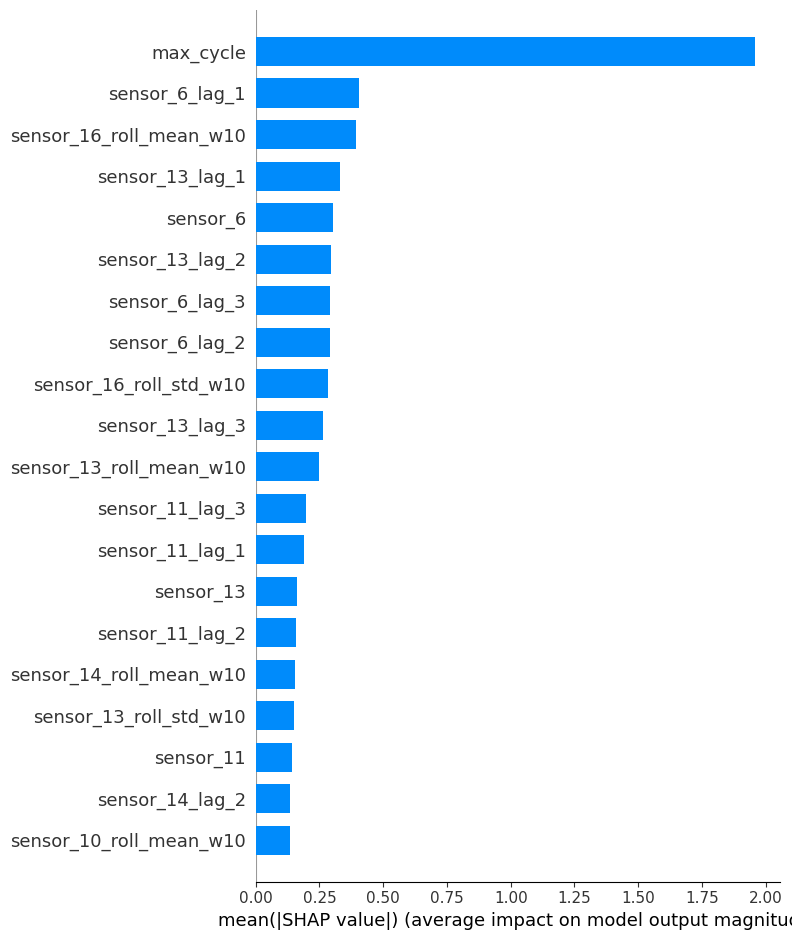


Top 10 Important Features:
                     feature  importance
171                max_cycle    1.956515
92            sensor_6_lag_1    0.405192
69   sensor_16_roll_mean_w10    0.392307
99           sensor_13_lag_1    0.330321
8                   sensor_6    0.302110
120          sensor_13_lag_2    0.295144
134           sensor_6_lag_3    0.291167
113           sensor_6_lag_2    0.291077
70    sensor_16_roll_std_w10    0.283104
141          sensor_13_lag_3    0.265103

Bottom 10 Least Important Features:
              feature  importance
126   sensor_19_lag_2         0.0
112    sensor_5_lag_2         0.0
154   sensor_5_zscore         0.0
150   sensor_1_zscore         0.0
146   sensor_18_lag_3         0.0
147   sensor_19_lag_3         0.0
159  sensor_10_zscore         0.0
165  sensor_16_zscore         0.0
167  sensor_18_zscore         0.0
168  sensor_19_zscore         0.0


In [ ]:
# 1. Train best classifier if not already trained
best_classifier = xgb.XGBClassifier(**best_params)
best_classifier.fit(X_train, y_train_clf)
import shap
# 2. Use TreeExplainer to get SHAP values
explainer = shap.Explainer(best_classifier)
shap_values = explainer(X_test)

# 3. Plot SHAP summary (optional for visual inspection)
shap.summary_plot(shap_values, X_test, plot_type='bar')

# 4. Get mean absolute SHAP values per feature
shap_importance = pd.DataFrame({
    'feature': X_test.columns,
    'importance': np.abs(shap_values.values).mean(axis=0)
}).sort_values(by='importance', ascending=False)

# Display top and bottom features
print("\nTop 10 Important Features:")
print(shap_importance.head(10))

print("\nBottom 10 Least Important Features:")
print(shap_importance.tail(10))


In [ ]:
print(shap_importance)

                     feature  importance
171                max_cycle    1.956515
92            sensor_6_lag_1    0.405192
69   sensor_16_roll_mean_w10    0.392307
99           sensor_13_lag_1    0.330321
8                   sensor_6    0.302110
..                       ...         ...
147          sensor_19_lag_3    0.000000
159         sensor_10_zscore    0.000000
165         sensor_16_zscore    0.000000
167         sensor_18_zscore    0.000000
168         sensor_19_zscore    0.000000

[172 rows x 2 columns]


In [ ]:
# Step 1: Fit your final XGBoost classifier (if not already done)
best_classifier = xgb.XGBClassifier(**best_params)
best_classifier.fit(X_train, y_train_clf)

# Step 2: Get feature importances from the trained model
importances = best_classifier.feature_importances_
feature_names = X_train.columns

# Step 3: Create a DataFrame to inspect
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=True)

# Step 4: Identify and list zero-importance features
zero_importance_features = importance_df[importance_df['importance'] == 0]['feature'].tolist()

print(f"\n🧹 Zero Importance Features ({len(zero_importance_features)}):")
print(zero_importance_features)

# Step 5: Drop them from train and test sets
X_train_reduced = X_train.drop(columns=zero_importance_features)
X_test_reduced = X_test.drop(columns=zero_importance_features)

# (Optional) Update your feature list
feature_cols = X_train_reduced.columns.tolist()
print(feature_cols)


🧹 Zero Importance Features (25):
['op_setting_3', 'sensor_5', 'sensor_10', 'sensor_16', 'sensor_18', 'sensor_19', 'sensor_19_lag_2', 'sensor_18_lag_2', 'sensor_16_lag_1', 'sensor_18_lag_1', 'sensor_19_lag_1', 'sensor_5_lag_2', 'sensor_19_diff', 'sensor_5_lag_1', 'sensor_19_roll_std_w10', 'sensor_18_diff', 'sensor_18_zscore', 'sensor_16_zscore', 'sensor_19_lag_3', 'sensor_5_zscore', 'sensor_10_zscore', 'sensor_18_lag_3', 'sensor_1_zscore', 'sensor_19_zscore', 'sensor_5_lag_3']
['op_setting_1', 'op_setting_2', 'sensor_1', 'sensor_2', 'sensor_3', 'sensor_4', 'sensor_6', 'sensor_7', 'sensor_8', 'sensor_9', 'sensor_11', 'sensor_12', 'sensor_13', 'sensor_14', 'sensor_15', 'sensor_17', 'sensor_20', 'sensor_21', 'sensor_1_roll_mean_w10', 'sensor_1_roll_std_w10', 'sensor_1_diff', 'sensor_2_roll_mean_w10', 'sensor_2_roll_std_w10', 'sensor_2_diff', 'sensor_3_roll_mean_w10', 'sensor_3_roll_std_w10', 'sensor_3_diff', 'sensor_4_roll_mean_w10', 'sensor_4_roll_std_w10', 'sensor_4_diff', 'sensor_5_rol

In [ ]:
print(feature_cols)

['op_setting_1', 'op_setting_2', 'sensor_1', 'sensor_2', 'sensor_3', 'sensor_4', 'sensor_6', 'sensor_7', 'sensor_8', 'sensor_9', 'sensor_11', 'sensor_12', 'sensor_13', 'sensor_14', 'sensor_15', 'sensor_17', 'sensor_20', 'sensor_21', 'sensor_1_roll_mean_w10', 'sensor_1_roll_std_w10', 'sensor_1_diff', 'sensor_2_roll_mean_w10', 'sensor_2_roll_std_w10', 'sensor_2_diff', 'sensor_3_roll_mean_w10', 'sensor_3_roll_std_w10', 'sensor_3_diff', 'sensor_4_roll_mean_w10', 'sensor_4_roll_std_w10', 'sensor_4_diff', 'sensor_5_roll_mean_w10', 'sensor_5_roll_std_w10', 'sensor_5_diff', 'sensor_6_roll_mean_w10', 'sensor_6_roll_std_w10', 'sensor_6_diff', 'sensor_7_roll_mean_w10', 'sensor_7_roll_std_w10', 'sensor_7_diff', 'sensor_8_roll_mean_w10', 'sensor_8_roll_std_w10', 'sensor_8_diff', 'sensor_9_roll_mean_w10', 'sensor_9_roll_std_w10', 'sensor_9_diff', 'sensor_10_roll_mean_w10', 'sensor_10_roll_std_w10', 'sensor_10_diff', 'sensor_11_roll_mean_w10', 'sensor_11_roll_std_w10', 'sensor_11_diff', 'sensor_12_ro

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

In [ ]:
# --- 1. Data Preparation for LSTM ---
# Define sequence length (lookback window) - You can experiment with this value
SEQUENCE_LENGTH = 50

# Use the feature_cols list generated after feature selection
features_for_lstm = feature_cols

# Function to create sequences
def create_sequences(df, sequence_length, feature_columns):
    sequences = []
    labels = []
    for unit in df['unit_number'].unique():
        unit_df = df[df['unit_number'] == unit].copy()
        unit_features = unit_df[feature_columns].values
        unit_label = unit_df['label'].iloc[-1] # Use the label at the end of the sequence

        # Create sequences (can be overlapping or non-overlapping)
        # This example uses overlapping sequences
        for i in range(len(unit_features) - sequence_length + 1):
            sequences.append(unit_features[i:i+sequence_length])
            labels.append(unit_label)

    return np.array(sequences), np.array(labels)

# Create sequences from the telemetry dataframe
# Make sure telemetry dataframe is the one after feature engineering and labeling
X_lstm, y_lstm = create_sequences(telemetry, SEQUENCE_LENGTH, features_for_lstm)

print(f"Shape of LSTM input data (sequences): {X_lstm.shape}")
print(f"Shape of LSTM target data (labels): {y_lstm.shape}")

# Split data - Stratify to handle potential class imbalance
X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm = train_test_split(
    X_lstm, y_lstm, test_size=0.2, random_state=42, stratify=y_lstm
)

print(f"Shape of LSTM training sequences: {X_train_lstm.shape}")
print(f"Shape of LSTM testing sequences: {X_test_lstm.shape}")
print(f"Shape of LSTM training labels: {y_train_lstm.shape}")
print(f"Shape of LSTM testing labels: {y_test_lstm.shape}")

Shape of LSTM input data (sequences): (29416, 50, 147)
Shape of LSTM target data (labels): (29416,)
Shape of LSTM training sequences: (23532, 50, 147)
Shape of LSTM testing sequences: (5884, 50, 147)
Shape of LSTM training labels: (23532,)
Shape of LSTM testing labels: (5884,)


In [ ]:
# --- 2. LSTM Model Architecture ---
lstm_model = Sequential()
lstm_model.add(LSTM(units=64, return_sequences=True, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(units=32, return_sequences=False))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(units=1, activation='sigmoid')) # Sigmoid for binary classification

# --- 3. Training the LSTM ---
# Ensure F1Score is imported and used correctly
# The metric is applied automatically during model.compile and model.fit
lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.F1Score(average='weighted')])

print("\nTraining LSTM model...")
history = lstm_model.fit(
    X_train_lstm, y_train_lstm,
    epochs=20, # Adjust epochs as needed
    batch_size=64, # Adjust batch size as needed
    validation_split=0.1 # Use a portion of training data for validation
)

# --- 4. Evaluate the LSTM model ---
print("\nEvaluating LSTM model...")
# The evaluate method will also calculate the metrics specified in compile
loss_lstm, accuracy_lstm, f1_score_lstm = lstm_model.evaluate(X_test_lstm, y_test_lstm, verbose=0)

print("\nLSTM Test Loss:", loss_lstm)
print("LSTM Test Accuracy:", accuracy_lstm)
print("LSTM Test F1 Score:", f1_score_lstm)

# Prediction example (moved outside of evaluation block)
y_pred_proba_lstm = lstm_model.predict(X_test_lstm)
y_pred_lstm = (y_pred_proba_lstm > 0.5).astype(int) # Apply a threshold

Shape of LSTM input data (sequences): (29416, 50, 147)
Shape of LSTM target data (labels): (29416,)
Shape of LSTM training sequences: (23532, 50, 147)
Shape of LSTM testing sequences: (5884, 50, 147)
Shape of LSTM training labels: (23532, 1)
Shape of LSTM testing labels: (5884, 1)

Training LSTM model...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
331/331 ━━━━━━━━━━━━━━━━━━━━ 32s 84ms/step - accuracy: 0.9836 - f1_score: 1.0000 - loss: 0.1030 - val_accuracy: 1.0000 - val_f1_score: 1.0000 - val_loss: 0.0015
Epoch 2/20
331/331 ━━━━━━━━━━━━━━━━━━━━ 41s 83ms/step - accuracy: 1.0000 - f1_score: 1.0000 - loss: 0.0015 - val_accuracy: 1.0000 - val_f1_score: 1.0000 - val_loss: 5.9244e-04
Epoch 3/20
331/331 ━━━━━━━━━━━━━━━━━━━━ 41s 84ms/step - accuracy: 1.0000 - f1_score: 1.0000 - loss: 6.8392e-04 - val_accuracy: 1.0000 - val_f1_score: 1.0000 - val_loss: 3.2447e-04
Epoch 4/20
331/331 ━━━━━━━━━━━━━━━━━━━━ 28s 84ms/step - accuracy: 1.0000 - f1_score: 1.0000 - loss: 4.0638e-04 - val_accuracy: 1.0000 - val_f1_score: 1.0000 - val_loss: 2.0066e-04
Epoch 5/20
331/331 ━━━━━━━━━━━━━━━━━━━━ 29s 87ms/step - accuracy: 1.0000 - f1_score: 1.0000 - loss: 2.6927e-04 - val_accuracy: 1.0000 - val_f1_score: 1.0000 - val_loss: 1.3336e-04
Epoch 6/20
331/331 ━━━━━━━━━━━━━━━━━━━━ 27s 83ms/step - accuracy: 1.0000 - f1_score: 1.0000 - loss: 1.8819e-04 -


LSTM Classification Report:
              precision    recall  f1-score   support

           1      1.000     1.000     1.000      5884

    accuracy                          1.000      5884
   macro avg      1.000     1.000     1.000      5884
weighted avg      1.000     1.000     1.000      5884



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


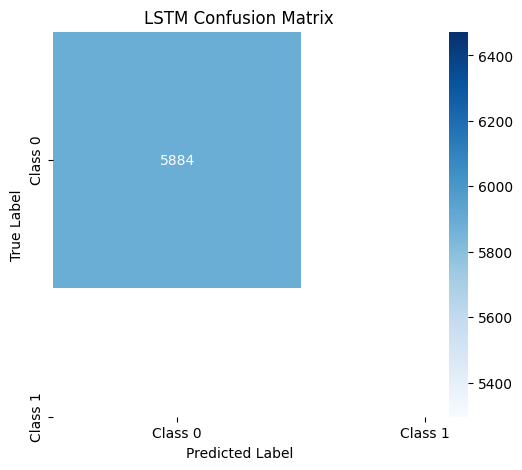

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:1179: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(


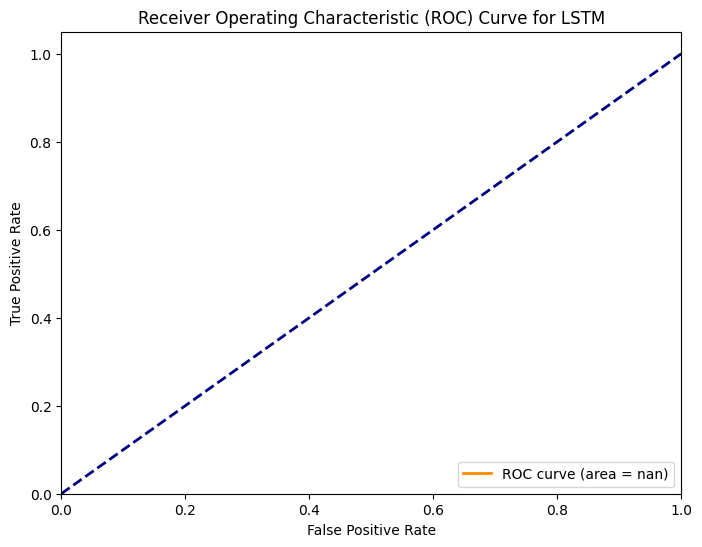


LSTM model saved successfully as 'lstm_failure_prediction_model'


In [ ]:
# --- 5. Display Classification Report ---
from sklearn.metrics import classification_report

print("\nLSTM Classification Report:")
print(classification_report(y_test_lstm, y_pred_lstm, digits=3))

# --- 6. Confusion Matrix ---
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

conf_matrix = confusion_matrix(y_test_lstm, y_pred_lstm)

plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('LSTM Confusion Matrix')
plt.show()

# --- 7. ROC Curve and AUC ---
from sklearn.metrics import roc_curve, auc

# For ROC curve, use the probabilities of the positive class (class 1)
# y_test_lstm needs to be 1D for roc_curve
fpr, tpr, thresholds = roc_curve(y_test_lstm.flatten(), y_pred_proba_lstm.flatten())
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for LSTM')
plt.legend(loc="lower right")
plt.show()

# --- 8. Save the LSTM Model ---
# You can save the model in different formats like HDF5 or SavedModel
# SavedModel is the default and recommended format
try:
    lstm_model.save('lstm_failure_prediction_model.h5')
    print("\nLSTM model saved successfully as 'lstm_failure_prediction_model'")
except Exception as e:
    print(f"Error saving LSTM model: {e}")

# To load the model later:
# loaded_lstm_model = tf.keras.models.load_model('lstm_failure_prediction_model')